In [1]:
# google colab configurations 
# these might change
DATA_GENERATION = '13kwW8C01etWsqTYoE2eeFlD4Ft9YVhrw'
DATA_GENERATION_FILE = 'datageneration.py'

HELPERS = '1zskLM0-ZtEQYVI7zvd2ePqtkTOkJmVIL'
HELPERS_FILE = 'helpers.py'

google_colab = input('Running on Colab?\n')
if google_colab=='yes' : 
    from pydrive.auth import GoogleAuth
    from pydrive.drive import GoogleDrive
    from google.colab import auth
    from oauth2client.client import GoogleCredentials

    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    drive = GoogleDrive(gauth)
    datageneration = drive.CreateFile({'id':DATA_GENERATION})
    datageneration.GetContentFile(DATA_GENERATION_FILE)

    helpers = drive.CreateFile({'id':HELPERS})
    helpers.GetContentFile(HELPERS_FILE)

  

  



Running on Colab?
yes


In [0]:
# checking whether CUDA is available 
train_on_gpu = torch.cuda.is_available()
if(train_on_gpu):
    print('Training on GPU!')
else: 
    print('No GPU available, training on CPU)

In [0]:
# pytorch imports
import torch
from torch import nn
from torch.nn.functional import softplus
from torch import optim
from torch.utils import data
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.normal import Normal


# general helpers
import matplotlib.pyplot as plt
import numpy as np
import collections
# custom imports

from datageneration import DataGenerator
from helpers import Helper

## Workflow of the implementation

- CNPS as Gaussian Processes try to learn a distribution over the functional value vector $V=(f(x_1).....f(x_n))$
- At test time any function from this distribution can be approximated
- The function will take into consideration the context points that have beeen give to make one function from this distribution more likely than others.

### Data Generation:
- The training points come from various functions that share some common characteristic
- In this implemenation the different functions come from __one__ Gaussian process
- A GP is a multivariate normal distribution, aka a mean and covariance matrix, where each dimension of the infinite random vector is a, aka random variable, is the functional value for a given input value.


1. The Kernel - __Creates a covariance matrix__: A function that takes in x values and returns a co-variance matrix. Here the Gaussian Kernel, RBF, or squared exponential is used. It computes the differences between all one dimensional feature vectors scales this distance by ``l``, squares it and scales it again by ``sigma_f``. As seen in other implementations (<a href = https://www.inf.ed.ac.uk/teaching/courses/mlpr/2019/notes/gp_minimal.py> GP demo</a>) some noises is added to the diagonal or to the variance of the covariance matrix to ensure a positive definite matrix and thus allow the Cholesky decomposition to be defined.
<br><br>
2. Curve Generator - __Generates functions from a GP__: We first set ``num_context_points`` <br>
__Training__: The number of target points is a random share of the context points. Random ``x_values`` are generated from a ``uniform`` between `-2` and `2`. Each of the ``batch_size`` vectors of context points is 1 by ``num_context_points``.<br>
__Testing__:For testing more ``targets`` (400) are created and are simply set at ``0.001`` intervals between `-2` and `2`.  <br><br>
The Kernel scale parameters are set and the ``x_values`` are past through the ``kernel`` to create the covariance matrix. The covariance matrix is decomposed with the ``cholesky``decomposition. The ``y_values`` are created through the following process:
Given the standardization of a non-standard multivariate normal $Z=\frac{X-\mu}{\sigma}$ we can create the non-standard multivariate normal by $L^-1*Z+\mu=Z$ where $L^-1$ is the Cholesky.

Finally, depending on training/ testing the appropriate number of points are selected from the ``x_values`` and the ``y_values``.

### Training, predicting with GPs:

GPs during training build the posterior distribution conditioned on the observed data.
At test time this distribution serves as the prior which will then be updated using the Bayes rule. Drawing from this distribution or taking the expected value is the prediction.


## Covariance Function for Gaussian Process:
- The Covariance function encodes our believes about the function to be generated/ learned 
- It encodes notion of similarity, i.e. similar inputs produce similar outputs
- Different factors influence the choice of the covariance function
- __Stationary covariance__ function is invariant to translations on the input space
 - I guess this it is constant when the inputs are transformed 
- __Isotropy or isotropic__ covariance functions are functions only of $|X_1-X_2|$, i.e. $K(X_1,X_2)$.
- The function only depends on the distance between the two input vectors
- This implementation uses the squared expnential, aka Radial Basis Function aka Gaussian Kernel

## Generating a dataset

In [0]:
datagenerator = DataGenerator(xdim=1,ydim=1,num_instances=2000, range_x=(-2,2),steps=500)
x_values,func_x = datagenerator.generate_curves()
func_x = Helper.list_np_to_sensor(func_x)
x_values = x_values.repeat(func_x.shape[0],1,1)

In [0]:
TRAIN_SHARE = 0.999
TRAIN_LEN = int(x_values.shape[0]*TRAIN_SHARE)

In [0]:
traindata = data.TensorDataset(x_values[:TRAIN_LEN], func_x[:TRAIN_LEN])
trainloader = data.DataLoader(traindata, batch_size=10)
validata = data.TensorDataset(x_values[TRAIN_LEN:], func_x[TRAIN_LEN:])
valiloader = data.DataLoader(validata, batch_size=1)

In [6]:
valiloader.dataset.tensors[0].shape

torch.Size([2, 500, 1])

## Encoder

The encoder creates a representation of the data context data. Some technicalilites to understand are the following: 
- The encoder simply takes a concatenation of the x,y values
- x values are of shape batch_size*number of context points, dimx
- y values are of shape batch_size*number of context points, 1
- the represenation ri can be of the dimensions that we choose.


In [0]:
class Encoder(nn.Module):
    
    
    """This class maps each x_i, y_i context point to a representation r_i
    To learn this Representation we are using a Multi Layer Perceptron
    The input shape will be batch_size, num_context_points, x_dim
    
    The input to the encoder are the value pairs, thus the dimensions are 
    Batch_Size, (dimx+dimy). The Pytorch automatically pases the values sequentially
    through the ANN.
    The last layer will not have an activation function because we want the pure represenation.
    
    Parameters
    ----------
    
    dimx : int
        Dimesion of each x value
    
    dimy : int
        Dimesion of each y value
        
    dimr : int
        Dimension of output representation
    
    dimh : tuple
        Dimension of hidden layers
    
    """
    
    
    def __init__(self, dimx, dimy, dimr, dimh):
        super().__init__()
            
        self._dimx = dimx
        self._dimy = dimy
        self._dimr = dimr
        self._dimh = dimh
        
        
        _first_layer = [nn.Linear(self._dimx+self._dimy, self._dimh[0]),nn.ReLU()]
        
        
        _hidden_layers = list(np.array([
            [nn.Linear(self._dimh[i], self._dimh[i+1]),nn.ReLU()]
            for i in range(len(self._dimh)-2)
        ]).flatten())
        
        _last_layer = [nn.Linear(self._dimh[-2], self._dimh[-1])]
        
        self._layers = _first_layer + _hidden_layers + _last_layer
        
        
        self._process_input = nn.Sequential(*self._layers)
    def forward(self, x_values, y_values):
        """
        Takes the context points x and y,
        concatenates them into value pairs
        and passes them through the MLP
        
        Parameters
        ----------
        
        x_values : torch.Tensor 
            Shape (batch_size, dimx)
            
        y_values : torch.Tensor 
            Shape (batch_size, dimy)
        
        """
        
        input_as_pairs = torch.cat((x_values, y_values), dim=1)

    
        return self._process_input(input_as_pairs)
        

## Aggregator

- The aggregator simply creates an aggregation'
- Here we simply take the average of ri

In [0]:
def aggregate(ri_tensor):
    """Takes a tensor of shape (batch_size,num_context_points, dimr) and aggregates it a
    along the second axis so that we have an aggregation across each batch
    
    Parameters
    ----------
    
    ri_tensor : Tensor
        Tensor of the representation of the x and y context points
    """
    
    return ri_tensor.mean(dim=1)
    

## Decoder

- The decoder takes the context points and the representation, passes them through an MLP and returns an output of dimensions two
- These two are used to minimize the negative log conditinal ligelihood which is a function that depends on the mu and sigma
- By minimize this quantitiy we find the correct parameters to the distribution of the Gaussian process from which the context points were drawn.
- We need to get 

In [0]:
class Decoder(nn.Module):
    
    """The decoder takes in x_values, that is the target points and combines them with
    the represenation of the context points by concatenation. The resulting tensor is passed to an MLP that 
    is asked to ouput the parameters for the sought after distribution, in this case
    a normal distribution. Thus we are looking for two parameters. The MLP returns two tensor obejects
    which hold a mean/ variance for each point y. Thus the shape of this output is 
    batch_size,y_values,y_dim, 2
    
    Note the targets consist
    of both the context points as well as the target points, since the context points
    are a subset of the target points.
    
    
    Parameters
    ----------
        
    dimx : int
        Dimension of each x value
    
    dimr : int
        Dimension of each of the representations
    
    *args : tuple
        Dimensions of the hidden layers 
             
    """
    
    def __init__(self,dimx, dimr,dimparam,dimh):
        super().__init__()
        
        
        self._dimx = dimx
        self._dimr = dimr
        self._dimparam = dimparam
        self._dimh = dimh
        
        _first_layer = [nn.Linear(self._dimx+self._dimr, self._dimh[0]),nn.ReLU()]
        
        _hidden_layers = list(np.array([
            [nn.Linear(self._dimh[i], self._dimh[i+1]),nn.ReLU()]
            for i in range(len(self._dimh)-1)
        ]).flatten())
        
        _last_layer = [nn.Linear(self._dimh[-1], self._dimparam)]
        
        self._layers = _first_layer + _hidden_layers + _last_layer
        
        
        self._process_input = nn.Sequential(*self._layers)
        
    def forward(self, x_values,r_values):
        
        """Takes x and r values, combines them and passes them twice to MLP. 
        Thus we have one run for mu and one run for sigma"""
        
        input_as_pairs = torch.cat((x_values, r_values),dim=1)
        
        dist_params = self._process_input(input_as_pairs)
        return self._process_input(input_as_pairs)     

In [0]:
def transform_var(var_tensor):
    
    '''This function takes a learned variance tensor and transforms 
    it following the methodology in Empirical Evaluation of Neural Process Objectives.
    This ensures that the covariance matrix is positive definite and a multivariate
    Gaussian can be constructed.
    Next it pads the diagonal with zeroes to create a covariance matrix for sampling.
   '''
    transformed_variance =  0.1+0.9*softplus(var_tensor)
    cov_matrix = torch.diag_embed(transformed_variance)
    return cov_matrix

In [0]:
def calc_loss (mu,sigma, targets):
    """Takes mean and variance arranges them in the appropriate shapes and creates a multivariate normal
        
    Parameters
    ----------
        
    mu : Tensor
        (Batch_size, num_target) dimensional vector with mean estimate for each target
    
    sigma : Tensor
        (Batch_size, num_target) dimensional vector holding the variance estimate for each target
            
    targets : Tensor 
        (batch_size,num_targets, ydim) dimensional vector with the targets
        
        """
#   padding the variance vector with zeros of the diagonal  
    cov_matrix = torch.diag_embed(sigma)
    distribution = MultivariateNormal(loc=mu, covariance_matrix=cov_matrix)
    loss = distribution.log_prob(targets.squeeze(-1))
        
    return distribution,torch.mean(loss)

In [0]:
class Trainer(nn.Module):
    
    def __init__(self,
                 n_epochs,
                 lr,
                 max_funcs,
                 max_contx,
                 min_contx,
                 dim_observation,
                 dimx=1,
                 dimy=1,
                 dimr=50,
                 dimout=2,
                 dim_encoder=[128,128,128],
                 dim_decoder=[128,128,128]):
        super().__init__()
    
        self._n_epochs = n_epochs
        self._lr = lr
        self._max_trgts = max_funcs
        self._max_contx = max_contx
        self._min_contx = min_contx
        self._dim_observation = dim_observation
        self._dimx = dimx
        self._dimy = dimy
        self._dimr = dimr
        self._dimout = dimout
        self._dim_encoder = dim_encoder
        self._dim_decoder = dim_decoder
    
    def _get_sample_indexes(self, both=True):
        num_contxt = np.random.randint(self._min_contx, self._max_contx)
        num_trgts = np.random.randint(self._max_contx,self._max_trgts)  
        trgts_idx = np.random.choice(np.arange(0,self._dim_observation), num_trgts)
        contxt_idx = trgts_idx[:num_contxt]
        if both:
            return trgts_idx, contxt_idx
        else:
            return contxt_idx
    def _validation_run(self, valiloader, encoder, decoder):
        with torch.no_grad():
for xvalues, funcvalues in valiloader:
                                batch_size = xvalues.shape[0]
                                num_trgt = self._dim_observation

                                target_y = funcvalues[:,:,:]
                                target_x = xvalues[:,:,:]

                                context_y = funcvalues[:,contxt_idx,:]
                                context_x = xvalues[:,contxt_idx,:]

                                # the encoding is stacked to ensure a one dimensional input
                                context_y_stacked = context_y.view(batch_size*num_contxt,-1)
                                context_x_stacked = context_x.view(batch_size*num_contxt,-1)
                            

                                # running the context values through the encoding
                                encoding  = encoder(context_x_stacked,context_y_stacked)
                                encoding  = encoding.view(batch_size,num_contxt,-1)
                            # averaging the encoding 
                                encoding_avg  = encoding.mean(1)
                            # we need to unsqueeze and repeat the embedding
                            # because we need to pair it with every target
                                encoding_avg  = encoding_avg.unsqueeze(1)
                                encoding_exp  = encoding_avg.repeat(1,num_trgt,1)

                                encoding_stacked = encoding_exp.view(batch_size*num_trgt,-1)
                                target_x_stacked = target_x.view(batch_size*num_trgt,-1)

                                decoding = decoder(target_x_stacked,encoding_stacked)
                                decoding_rshp = decoding.view(batch_size,num_trgt,-1)


                                mu,sigma = decoding_rshp[:,:,0], decoding_rshp[:,:,1]
                                cov_matrix = transform_var(sigma)    
                                distribution = MultivariateNormal(loc=mu, covariance_matrix=cov_matrix)
                                plt.plot(target_x[0].flatten(),sigma.flatten())
                                plt.show()
                                plt.close()

                                plt.plot(target_x[0].flatten(),target_y.flatten())
                                plt.show()
                                plt.close()



    def run_training(self, trainloader, valiloader=None):
        # defining the Encoder and the Decoder nstances
        encoder = Encoder(self._dimx, self._dimy, self._dimr, self._dim_encoder)
        decoder = Decoder(self._dimx, self._dim_encoder[-1], self._dimout, self._dim_decoder)

        if train_on_gpu:
            encoder.cuda()
            decoder.cuda()


        optimizer = optim.Adam(decoder.parameters())
        mean_epoch_loss = []
        
        for epoch in range(self._n_epochs):
            running_loss = 0
#         get sample indexes
            for xvalues, funcvalues in trainloader:
                xvalues, funcvalues = xvales.cuda(), funcvalues.cuda()

                optimizer.zero_grad()
#           we sample for every single batch  
#           Setting the batch size here is not ideal
                batch_size = xvalues.shape[0]
            
                func_idx, contxt_idx = self._get_sample_indexes()
                num_trgt,num_contxt = len(func_idx),len(contxt_idx)
                
                target_y = funcvalues[:,func_idx,:]
                target_x = xvalues[:,func_idx,:]
                
                context_y = funcvalues[:,contxt_idx,:]
                context_x = xvalues[:,contxt_idx,:]
                
                
                # the encoding is stacked to ensure a one dimensional input
                context_y_stacked = context_y.view(batch_size*num_contxt,-1)
                context_x_stacked = context_x.view(batch_size*num_contxt,-1)

                # running the context values through the encoding
                encoding  = encoder(context_x_stacked, context_y_stacked)
                encoding  = encoding.view(batch_size, num_contxt,-1)
                # averaging the encoding 
                encoding_avg  = encoding.mean(1)
                # we need to unsqueeze and repeat the embedding
                # because we need to pair it with every target
                encoding_avg  = encoding_avg.unsqueeze(1)
                encoding_exp  = encoding_avg.repeat(1,num_trgt,1)

                encoding_stacked = encoding_exp.view(batch_size*num_trgt,-1)
                target_x_stacked = target_x.view(batch_size*num_trgt,-1)
                
                decoding = decoder(target_x_stacked,encoding_stacked)
                decoding_rshp = decoding.view(batch_size,num_trgt,-1)
                
#              
                mu,sigma = decoding_rshp[:,:,0], decoding_rshp[:,:,1]
                
                
                cov_matrix = transform_var(sigma)    
                distribution = MultivariateNormal(loc=mu, covariance_matrix=cov_matrix)
#                 sigma_transformed = 0.1+0.9*softplus(sigma)
#                 distribution = Normal(mu,sigma_transformed)
                loss = distribution.log_prob(target_y.squeeze(-1))
                loss = -torch.mean(loss)
                mean_epoch_loss.append(loss)
                running_loss += loss
                
                loss.backward()
                optimizer.step()
            else:
                
                if epoch%100==0 and valiloader:
                        mean_epoch_loss.append(running_loss/len(trainloader))
                        print(f'Mean loss at epoch {epoch} : {mean_epoch_loss[-1]}')

                        with torch.no_grad():
                            for xvalues, funcvalues in valiloader:
                                batch_size = xvalues.shape[0]
                                num_trgt = self._dim_observation

                                target_y = funcvalues[:,:,:]
                                target_x = xvalues[:,:,:]

                                context_y = funcvalues[:,contxt_idx,:]
                                context_x = xvalues[:,contxt_idx,:]

                                # the encoding is stacked to ensure a one dimensional input
                                context_y_stacked = context_y.view(batch_size*num_contxt,-1)
                                context_x_stacked = context_x.view(batch_size*num_contxt,-1)
                            

                                # running the context values through the encoding
                                encoding  = encoder(context_x_stacked,context_y_stacked)
                                encoding  = encoding.view(batch_size,num_contxt,-1)
                            # averaging the encoding 
                                encoding_avg  = encoding.mean(1)
                            # we need to unsqueeze and repeat the embedding
                            # because we need to pair it with every target
                                encoding_avg  = encoding_avg.unsqueeze(1)
                                encoding_exp  = encoding_avg.repeat(1,num_trgt,1)

                                encoding_stacked = encoding_exp.view(batch_size*num_trgt,-1)
                                target_x_stacked = target_x.view(batch_size*num_trgt,-1)

                                decoding = decoder(target_x_stacked,encoding_stacked)
                                decoding_rshp = decoding.view(batch_size,num_trgt,-1)


                                mu,sigma = decoding_rshp[:,:,0], decoding_rshp[:,:,1]
                                cov_matrix = transform_var(sigma)    
                                distribution = MultivariateNormal(loc=mu, covariance_matrix=cov_matrix)
                                plt.plot(target_x[0].flatten(),sigma.flatten())
                                plt.show()
                                plt.close()

                                plt.plot(target_x[0].flatten(),target_y.flatten())
                                plt.show()
                                plt.close()
                

In [0]:
class Trainer(nn.Module):
    
    def __init__(self,
                 n_epochs,
                 lr,
                 max_funcs,
                 max_contx,
                 min_contx,
                 dim_observation,
                 dimx=1,
                 dimy=1,
                 dimr=50,
                 dimout=2,
                 dim_encoder=[128,128,128],
                 dim_decoder=[128,128,128]):
        super().__init__()
    
        self._n_epochs = n_epochs
        self._lr = lr
        self._max_trgts = max_funcs
        self._max_contx = max_contx
        self._min_contx = min_contx
        self._dim_observation = dim_observation
        self._dimx = dimx
        self._dimy = dimy
        self._dimr = dimr
        self._dimout = dimout
        self._dim_encoder = dim_encoder
        self._dim_decoder = dim_decoder
    
    def _get_sample_indexes(self, both=True):
        num_contxt = np.random.randint(self._min_contx, self._max_contx)
        num_trgts = np.random.randint(self._max_contx,self._max_trgts)  
        trgts_idx = np.random.choice(np.arange(0,self._dim_observation), num_trgts)
        contxt_idx = trgts_idx[:num_contxt]
        if both:
            return trgts_idx, contxt_idx
        else:
            return contxt_idx


    def run_training(self, trainloader, valiloader=None):
        # defining the Encoder and the Decoder nstances
        encoder = Encoder(self._dimx, self._dimy, self._dimr, self._dim_encoder)
        decoder = Decoder(self._dimx, self._dim_encoder[-1], self._dimout, self._dim_decoder)
        optimizer = optim.Adam(decoder.parameters())
        mean_epoch_loss = []
        
        for epoch in range(self._n_epochs):
            running_loss = 0
#         get sample indexes
            for xvalues, funcvalues in trainloader:
                optimizer.zero_grad()
#           we sample for every single batch  
#           Setting the batch size here is not ideal
                batch_size = xvalues.shape[0]
            
                func_idx, contxt_idx = self._get_sample_indexes()
                num_trgt,num_contxt = len(func_idx),len(contxt_idx)
                
                target_y = funcvalues[:,func_idx,:]
                target_x = xvalues[:,func_idx,:]
                
                context_y = funcvalues[:,contxt_idx,:]
                context_x = xvalues[:,contxt_idx,:]
                
                
                # the encoding is stacked to ensure a one dimensional input
                context_y_stacked = context_y.view(batch_size*num_contxt,-1)
                context_x_stacked = context_x.view(batch_size*num_contxt,-1)

                # running the context values through the encoding
                encoding  = encoder(context_x_stacked, context_y_stacked)
                encoding  = encoding.view(batch_size, num_contxt,-1)
                # averaging the encoding 
                encoding_avg  = encoding.mean(1)
                # we need to unsqueeze and repeat the embedding
                # because we need to pair it with every target
                encoding_avg  = encoding_avg.unsqueeze(1)
                encoding_exp  = encoding_avg.repeat(1,num_trgt,1)

                encoding_stacked = encoding_exp.view(batch_size*num_trgt,-1)
                target_x_stacked = target_x.view(batch_size*num_trgt,-1)
                
                decoding = decoder(target_x_stacked,encoding_stacked)
                decoding_rshp = decoding.view(batch_size,num_trgt,-1)
                
#              
                mu,sigma = decoding_rshp[:,:,0], decoding_rshp[:,:,1]
                
                
                cov_matrix = transform_var(sigma)    
                distribution = MultivariateNormal(loc=mu, covariance_matrix=cov_matrix)
#                 sigma_transformed = 0.1+0.9*softplus(sigma)
#                 distribution = Normal(mu,sigma_transformed)
                loss = distribution.log_prob(target_y.squeeze(-1))
                loss = -torch.mean(loss)
                mean_epoch_loss.append(loss)
                running_loss += loss
                
                loss.backward()
                optimizer.step()
            else:
                
                if epoch%100==0 and valiloader:
                        mean_epoch_loss.append(running_loss/len(trainloader))
                        print(f'Mean loss at epoch {epoch} : {mean_epoch_loss[-1]}')

                        with torch.no_grad():
                            for xvalues, funcvalues in valiloader:
                                batch_size = xvalues.shape[0]
                                num_trgt = self._dim_observation

                                target_y = funcvalues[:,:,:]
                                target_x = xvalues[:,:,:]

                                context_y = funcvalues[:,contxt_idx,:]
                                context_x = xvalues[:,contxt_idx,:]

                                # the encoding is stacked to ensure a one dimensional input
                                context_y_stacked = context_y.view(batch_size*num_contxt,-1)
                                context_x_stacked = context_x.view(batch_size*num_contxt,-1)
                            

                                # running the context values through the encoding
                                encoding  = encoder(context_x_stacked,context_y_stacked)
                                encoding  = encoding.view(batch_size,num_contxt,-1)
                            # averaging the encoding 
                                encoding_avg  = encoding.mean(1)
                            # we need to unsqueeze and repeat the embedding
                            # because we need to pair it with every target
                                encoding_avg  = encoding_avg.unsqueeze(1)
                                encoding_exp  = encoding_avg.repeat(1,num_trgt,1)

                                encoding_stacked = encoding_exp.view(batch_size*num_trgt,-1)
                                target_x_stacked = target_x.view(batch_size*num_trgt,-1)

                                decoding = decoder(target_x_stacked,encoding_stacked)
                                decoding_rshp = decoding.view(batch_size,num_trgt,-1)


                                mu,sigma = decoding_rshp[:,:,0], decoding_rshp[:,:,1]
                                cov_matrix = transform_var(sigma)    
                                distribution = MultivariateNormal(loc=mu, covariance_matrix=cov_matrix)
                                plt.plot(target_x[0].flatten(),sigma.flatten())
                                plt.show()
                                plt.close()

                                plt.plot(target_x[0].flatten(),target_y.flatten())
                                plt.show()
                                plt.close()
                

In [0]:
### configuration from the paper implementation 
ENCODER_HIDDEN_DIMS = [128,128,128]
ENCODER_OUT_DIMS = 128
DECODER_HIDDEN_DIMS = [128,128]
DECODER_OUT_DIMS = 2
LEARNING_RATE = 0.001
MAX_CONTXT_POINTS = 5
MIN_CONTXT = 2
MAX_TARGET_POINTS = 10
N_EPOCHS = 10000
N_RANGE = 500
DIM_X = 1
DIM_Y = 1

In [0]:
trainer = Trainer(N_EPOCHS,
                  LEARNING_RATE,
                  MAX_TARGET_POINTS,
                  MAX_CONTXT_POINTS,
                  MIN_CONTXT,
                  N_RANGE,
                  DIM_X,
                  DIM_Y,
                  ENCODER_OUT_DIMS,
                  DECODER_OUT_DIMS,
                  ENCODER_HIDDEN_DIMS,
                  DECODER_HIDDEN_DIMS)

In [0]:
# debugging:
# check samlping strategy
# original paper takes points sequentiall--> contxt points+targetpoints

Mean loss at epoch 0 : 9.009370803833008


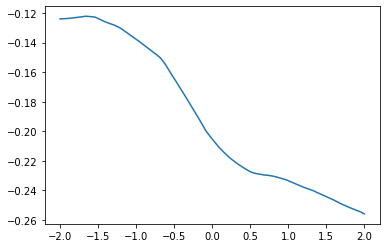

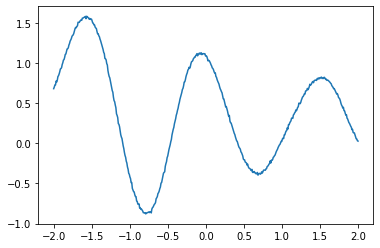

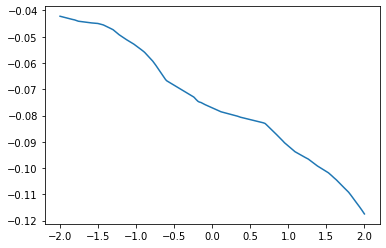

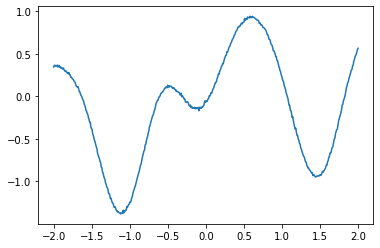

Mean loss at epoch 100 : 5.8923444747924805


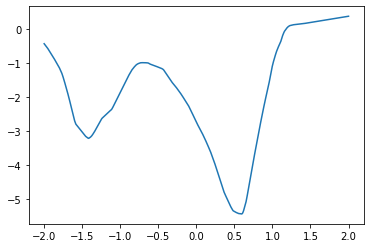

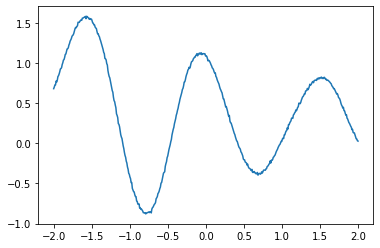

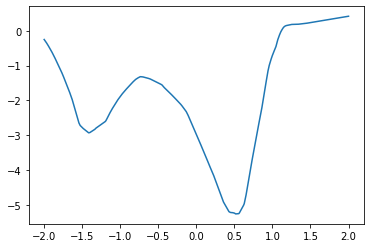

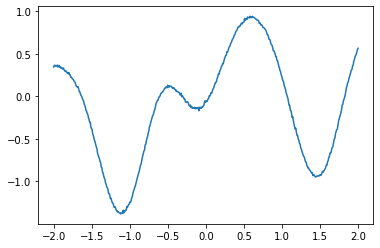

Mean loss at epoch 200 : 5.149564743041992


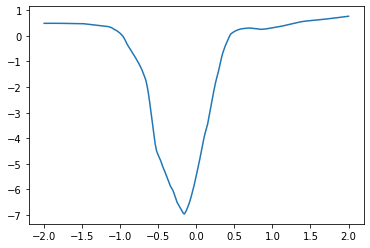

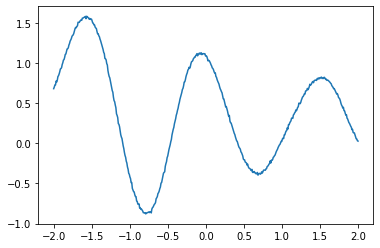

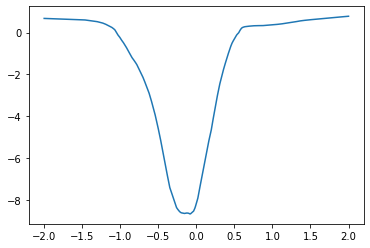

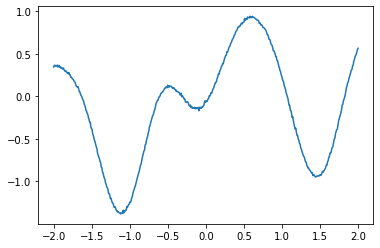

Mean loss at epoch 300 : 4.634131908416748


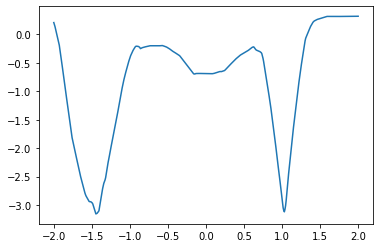

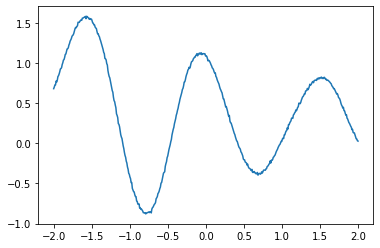

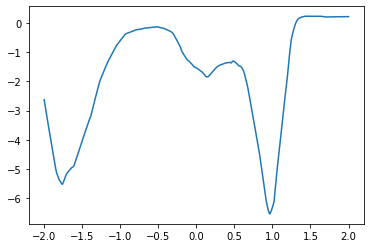

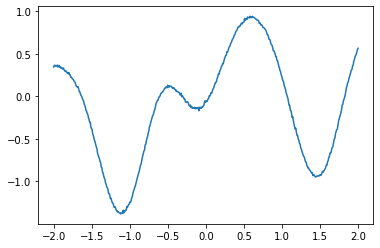

Mean loss at epoch 400 : 4.738485336303711


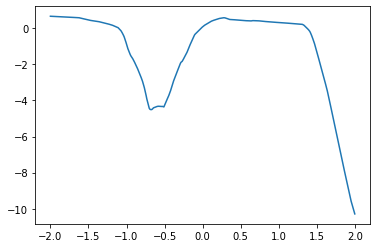

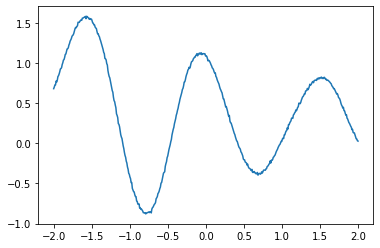

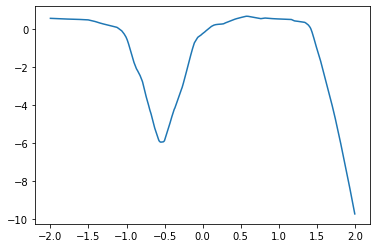

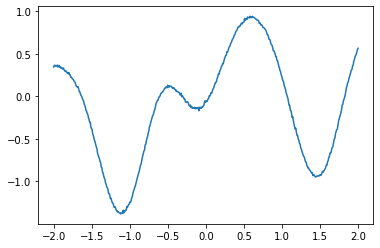

Mean loss at epoch 500 : 4.705639839172363


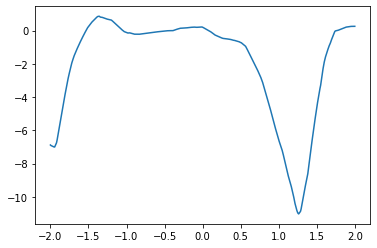

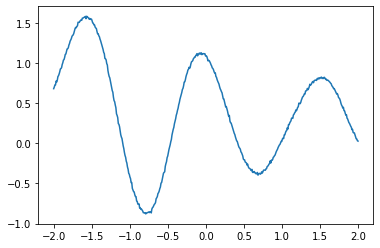

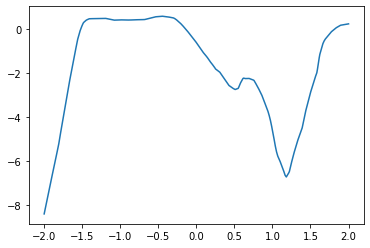

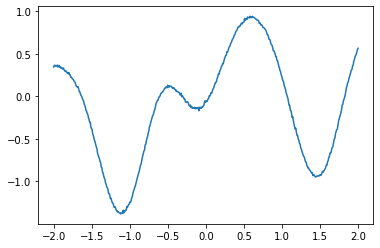

Mean loss at epoch 600 : 4.572202205657959


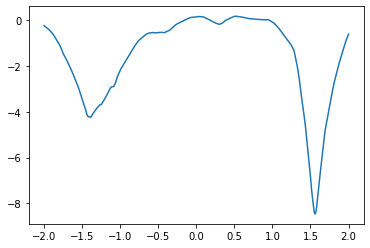

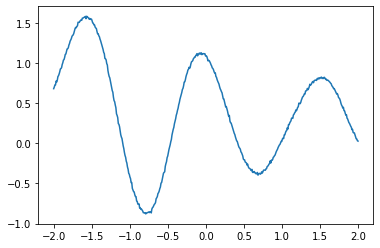

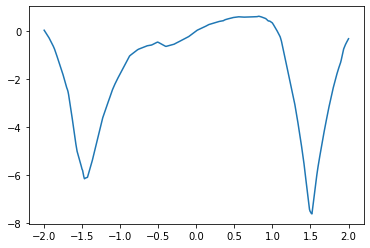

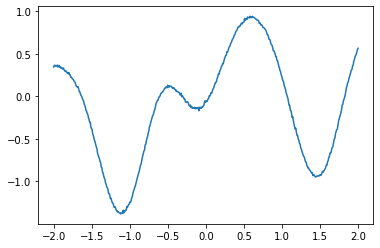

Mean loss at epoch 700 : 4.7314534187316895


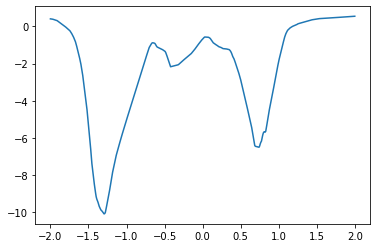

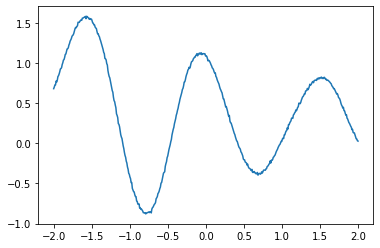

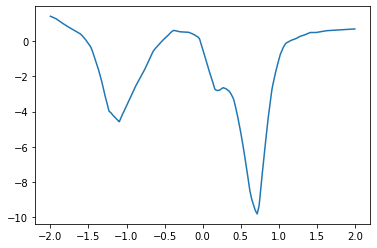

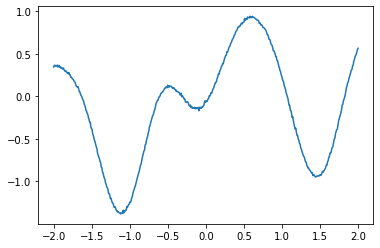

Mean loss at epoch 800 : 4.372829437255859


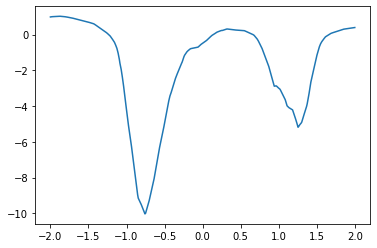

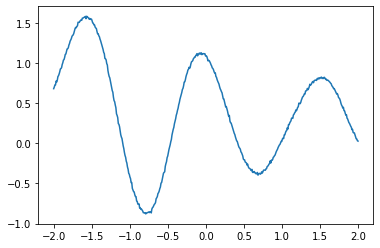

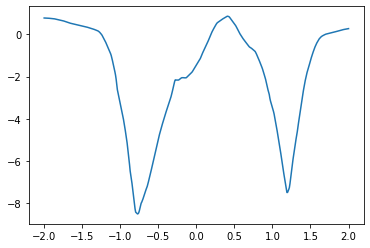

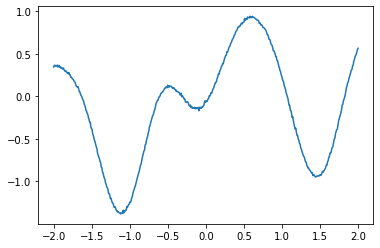

Mean loss at epoch 900 : 4.209048271179199


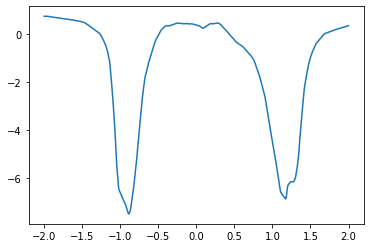

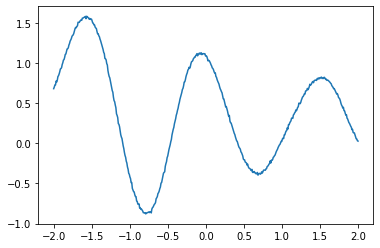

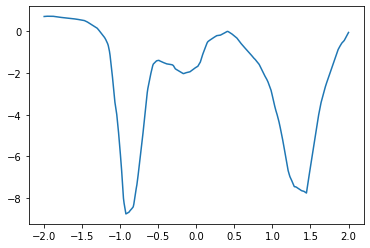

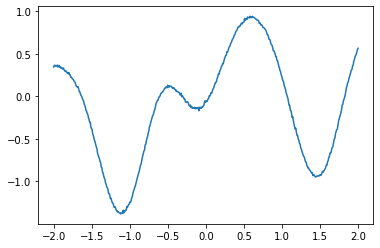

Mean loss at epoch 1000 : 4.376528263092041


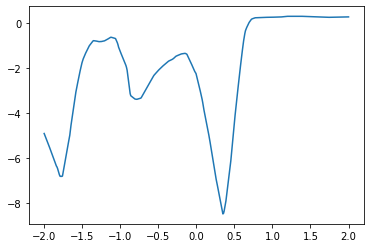

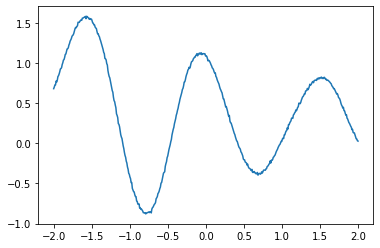

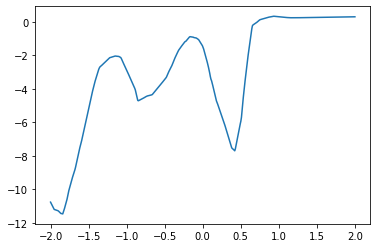

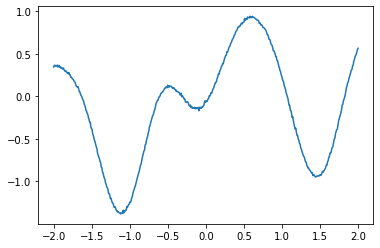

Mean loss at epoch 1100 : 4.598963260650635


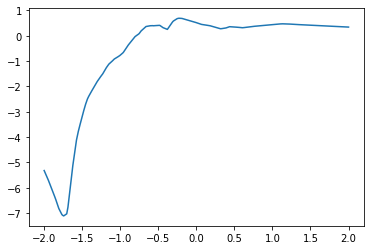

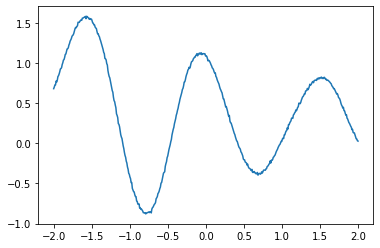

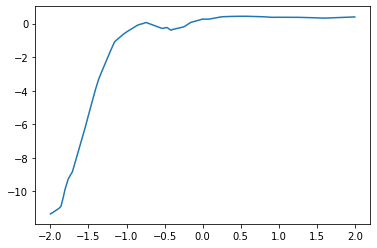

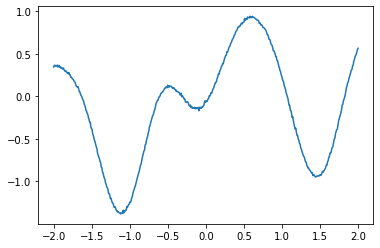

Mean loss at epoch 1200 : 4.152984142303467


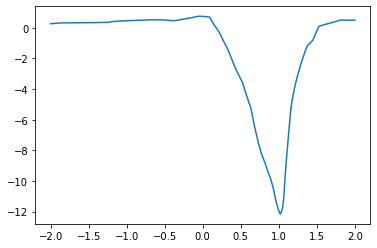

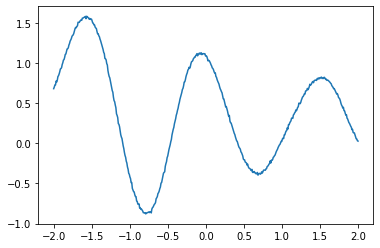

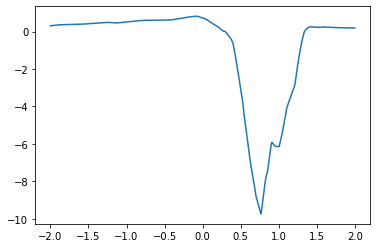

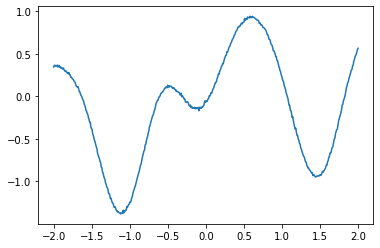

Mean loss at epoch 1300 : 4.5321364402771


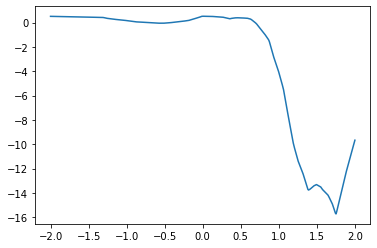

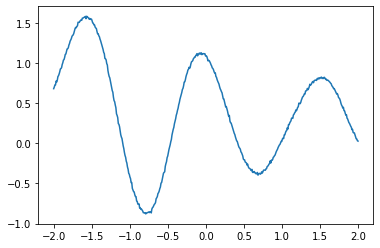

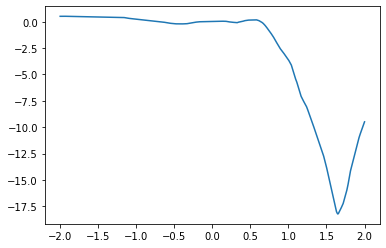

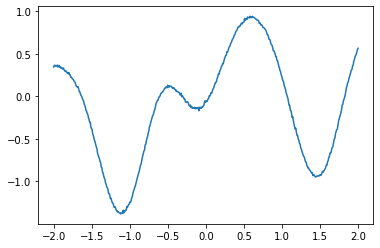

Mean loss at epoch 1400 : 4.568881988525391


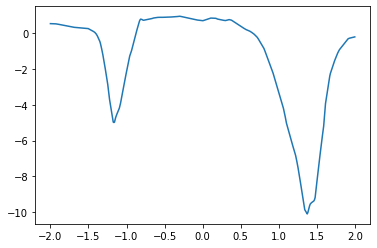

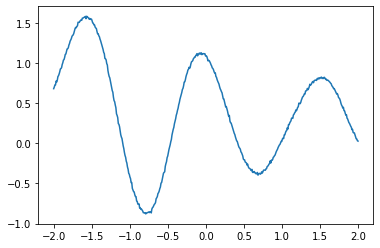

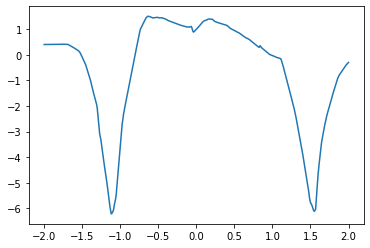

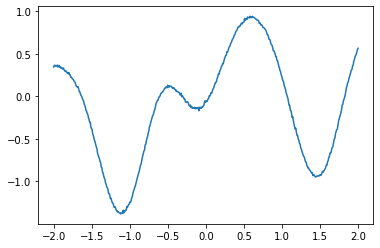

Mean loss at epoch 1500 : 4.122498035430908


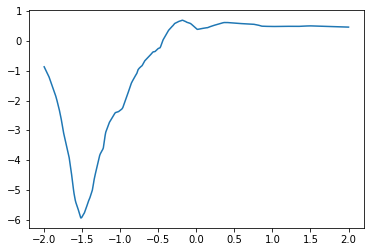

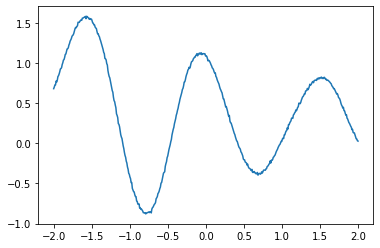

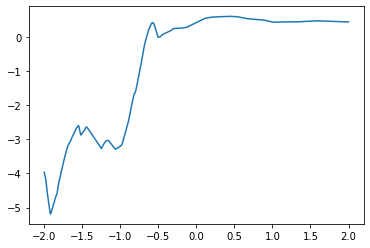

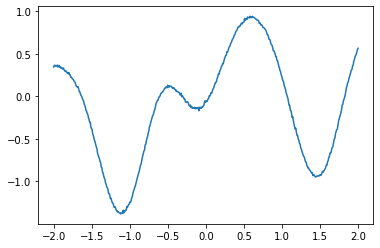

Mean loss at epoch 1600 : 4.064843654632568


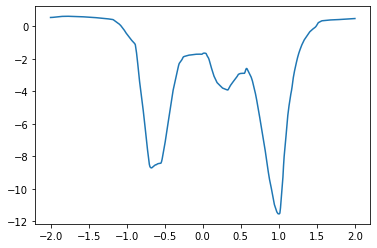

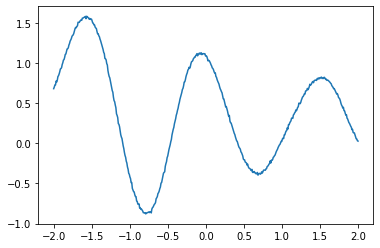

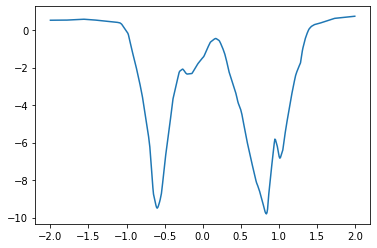

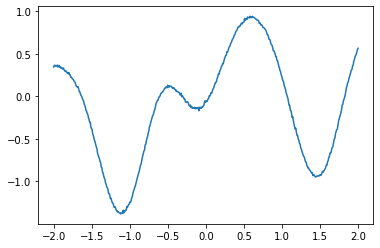

Mean loss at epoch 1700 : 4.486499309539795


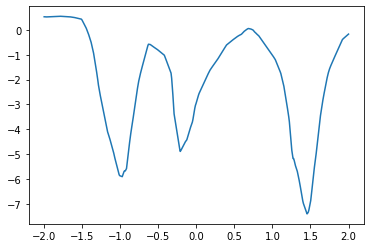

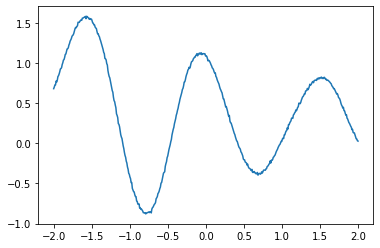

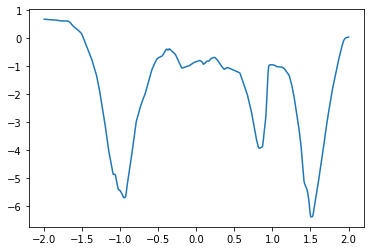

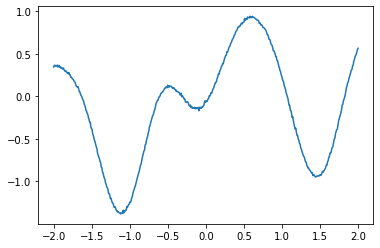

In [0]:
l= trainer.run_training(trainloader,valiloader)

 ## Sandbox - testing the individual parts of the function

### Kernel function
Expanding the dimesions of the tensors allows us substract each point pairwise
This being a 1-D use case we simply substract each of the data points and get an n by n matrix for each layer.

In [0]:
batch_size = 64
num_points = 10
dimx = 1
dimy = 1
rdim = 20
hdim = 20
x = Helper.scale_shift_uniform(-2,2,batch_size,num_points,dimx)
y = Helper.scale_shift_uniform(-2,2,batch_size,num_points,dimy)

x_stacked  = x.view(batch_size*num_points,-1)
y_stacked  = y.view(batch_size*num_points,-1)
encoder = Encoder(1,1,hdim,[hdim,hdim,rdim])
r  = encoder.forward(x_stacked,y_stacked)
r = r.view(batch_size,num_points,-1)
r_aggregate = aggregate(r).unsqueeze(1)
print(r_aggregate.shape)
r_aggregate = r_aggregate.repeat(1,num_points,1)
print(r_aggregate.shape)

hdim = 128
outdim = 2
decoder = Decoder(dimx,rdim,outdim,[hdim,hdim,hdim])

r_stacked = r_aggregate.view(batch_size*num_points,-1)
print(r_stacked.shape)
dist_params = decoder.forward(x_stacked, r_stacked).view(batch_size,num_points,-1)

mu = dist_params[:,:,0]
sigma = torch.diag_embed(dist_params[:,:,1])
sigma_test = torch.ones(10).unsqueeze(0).repeat(64,1)

